In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# üîπ Cargar los datos
df_btc = pd.read_csv("Database/btc_final.csv")

# üîπ Convertir fechas a datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

# üîπ Imputaci√≥n de valores faltantes
tech_indicators = ['BTC_EMA_20', 'BTC_RSI', 'BTC_MACD']  # Eliminamos BTC_SMA_50

# Obtener los primeros dos meses de datos
start_date = df_btc['Date'].min()
end_date = start_date + pd.DateOffset(months=2)
df_initial = df_btc[(df_btc['Date'] >= start_date) & (df_btc['Date'] < end_date)]

# Rellenar indicadores t√©cnicos con el promedio de los primeros dos meses
for col in tech_indicators:
    mean_value = df_initial[col].mean()
    df_btc.loc[:, col] = df_btc[col].fillna(mean_value)

# Rellenar Fear_Greed_Index con el promedio entre el valor anterior y el siguiente
df_btc.loc[:, 'Fear_Greed_Index'] = df_btc['Fear_Greed_Index'].interpolate(method='linear')

# üîπ Eliminar variables redundantes
#df_btc.drop(columns=['BTC_SMA_50', 'BTC_Price_CryptoCompare', 'Open', 'High', 'Low'], inplace=True, errors='ignore')

# üîπ Eliminar variables redundantes
df_btc.drop(columns=['BTC_SMA_50', 'Volume','BTC_Price_CryptoCompare', 'Open', 'High', 'Low', 'BTC_Trends'], inplace=True, errors='ignore') # 'BTC_Sentiment'

# üîπ Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df_btc.copy()
df_scaled[df_btc.columns.difference(['Date'])] = scaler.fit_transform(df_btc[df_btc.columns.difference(['Date'])])

# üîπ Mover la columna "Close" al final
df_scaled = df_scaled[[col for col in df_scaled.columns if col != "Close"] + ["Close"]]
# üîπ Eliminar la columna de fechas antes de guardar
df_scaled = df_scaled.drop(columns=['Date'], errors='ignore')

# üîπ Guardar datasets preprocesados
np.save("Dataset/df_scaled_btc.npy", df_scaled.values)
print("‚úÖ Datos preprocesados guardados en Dataset/")

2025-03-16 20:29:27.959943: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


‚úÖ Datos preprocesados guardados en Dataset/


#### Crear secuencias de tiempo (Seleccion aleatorea)

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# üîπ Cargar los datos normalizados
df_scaled = np.load("Dataset/df_scaled_btc.npy", allow_pickle=True)

# üîπ Crear secuencias para LSTM
sequence_length = 60  # 60 d√≠as de ventana
def create_sequences(data, target_index, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length, :-1])  # Features
        targets.append(data[i + sequence_length, target_index])  # Target
    return np.array(sequences), np.array(targets)

# Definir la posici√≥n de la variable objetivo (√∫ltima columna en df_scaled)
target_index = -1  # √öltima columna (precio futuro)

X, Y = create_sequences(df_scaled, target_index, sequence_length)

# üîπ Dividir en Train/Test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# üîπ Guardar datasets para evitar desorden
np.save("Dataset/X_train_btc.npy", X_train)
np.save("Dataset/X_test_btc.npy", X_test)
np.save("Dataset/y_train_btc.npy", y_train)
np.save("Dataset/y_test_btc.npy", y_test)
print("‚úÖ Datasets para LSTM guardados en Dataset/")

‚úÖ Datasets para LSTM guardados en Dataset/


#### definir y entrenar el modelo Bi-LSTM

Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 152ms/step - loss: 3.2263 - val_loss: 2.1023
Epoch 2/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 132ms/step - loss: 1.8150 - val_loss: 1.1496
Epoch 3/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 183ms/step - loss: 0.9883 - val_loss: 0.6163
Epoch 4/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 166ms/step - loss: 0.5216 - val_loss: 0.3152
Epoch 5/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 164ms/step - loss: 0.2662 - val_loss: 0.1634
Epoch 6/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 182ms/step - loss: 0.1323 - val_loss: 0.0784
Epoch 7/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 179ms/step - loss: 0.0649 - val_loss: 0.0527
Epoch 8/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 155ms/step - loss: 0.0321 - val_loss:

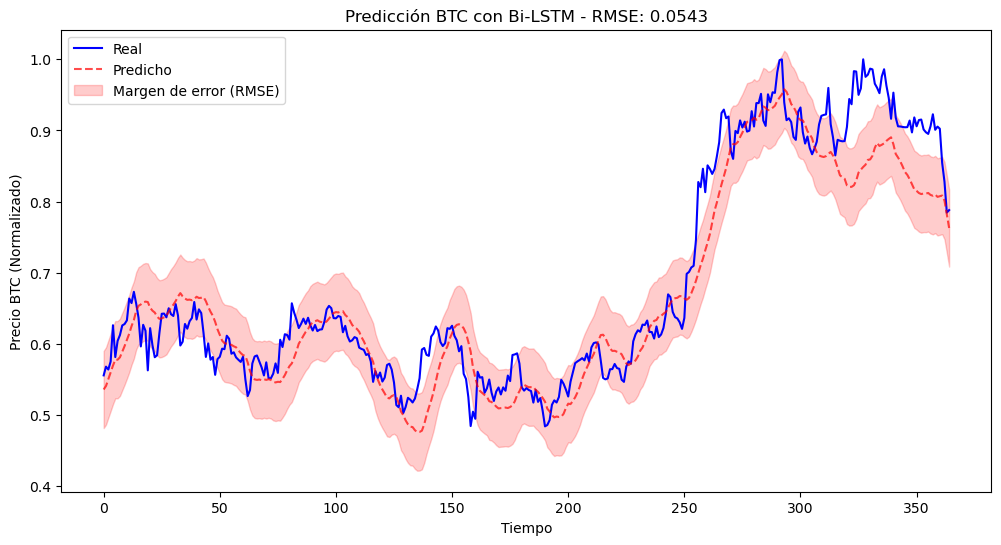

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# üîπ Cargar datasets preprocesados
X_train = np.load("Dataset/X_train_btc.npy")
X_test = np.load("Dataset/X_test_btc.npy")
y_train = np.load("Dataset/y_train_btc.npy")
y_test = np.load("Dataset/y_test_btc.npy")

# üîπ Construcci√≥n del modelo Bi-LSTM optimizado
model_btc = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='tanh')),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# üîπ Compilar modelo
model_btc.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# üîπ Early Stopping con m√°s paciencia para mejorar estabilidad
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# üîπ Entrenar el modelo
history = model_btc.fit(
    X_train, y_train,
    epochs=100,  # Probamos con m√°s √©pocas para aprovechar Early Stopping
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# üîπ Evaluaci√≥n del modelo
loss = model_btc.evaluate(X_test, y_test)
rmse = np.sqrt(loss)
print(f"üìâ RMSE del modelo: {rmse:.4f}")

# üîπ Obtener la desviaci√≥n real del precio de BTC en el dataset
btc_price_std = np.std(y_train) * 50000  # Ajustamos escala para convertirlo a USD
rmse_dollars = rmse * btc_price_std
print(f"üí∞ RMSE en d√≥lares: ${rmse_dollars:.2f}")

# üîπ Predicciones
y_pred = model_btc.predict(X_test)

# üîπ Gr√°fica mejorada de predicci√≥n vs. valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color='blue')
plt.plot(y_pred, label="Predicho", linestyle="dashed", color='red', alpha=0.7)
plt.fill_between(range(len(y_test)), y_pred.flatten() - rmse, y_pred.flatten() + rmse, color='red', alpha=0.2, label="Margen de error (RMSE)")
plt.xlabel("Tiempo")
plt.ylabel("Precio BTC (Normalizado)")
plt.legend()
plt.title(f"Predicci√≥n BTC con Bi-LSTM - RMSE: {rmse:.4f}")
plt.show()

In [6]:
# Guardar el modelo entrenado
model_btc.save("model_btc_Bi_LSTM.keras")
print("‚úÖ Modelo LSTM guardado en model_btc_Bi_LSTM.keras")

‚úÖ Modelo LSTM guardado en model_btc_Bi_LSTM.keras


12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 51ms/step 


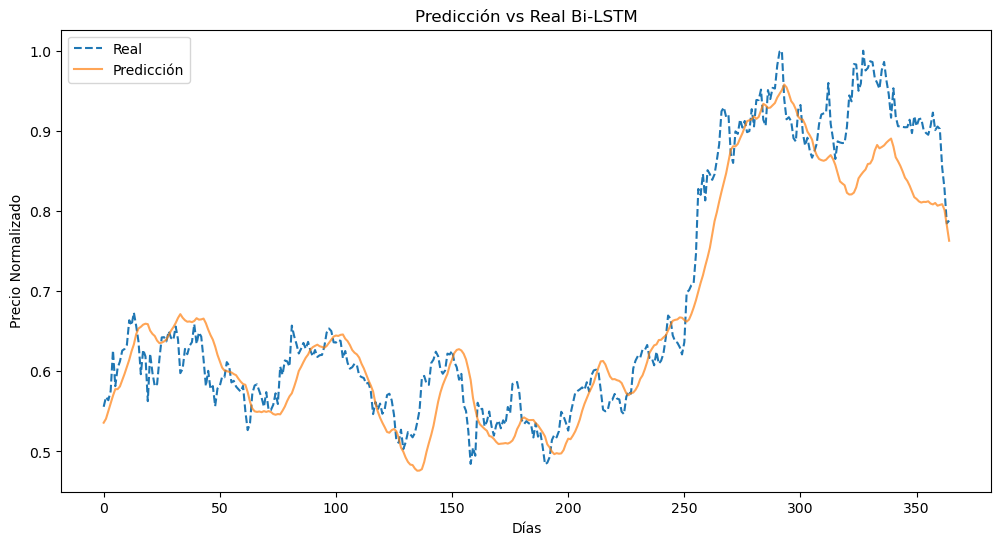

üí∞ RMSE en d√≥lares: $339.68
üìâ Error Cuadr√°tico Medio (MSE): 0.002468587566854753
üìâ Ra√≠z del Error Cuadr√°tico Medio (RMSE): 0.049684882679289416


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

# üîπ Cargar los datasets para evaluar el modelo
X_test = np.load("Dataset/X_test_btc.npy", allow_pickle=True)
y_test = np.load("Dataset/y_test_btc.npy", allow_pickle=True)

# üîπ Cargar el modelo entrenado
model = load_model("model_btc_Bi_LSTM.keras")

# üîπ Hacer predicciones
y_pred = model.predict(X_test)

# üîπ Desescalar los valores predichos y reales
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# üîπ Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", linestyle='dashed')
plt.plot(y_pred, label="Predicci√≥n", alpha=0.7)
plt.legend()
plt.title("Predicci√≥n vs Real Bi-LSTM")
plt.xlabel("D√≠as")
plt.ylabel("Precio Normalizado")
plt.show()

# üîπ Evaluar el modelo
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)

# üîπ Obtener la desviaci√≥n real del precio de BTC en el dataset
btc_price_std = np.std(y_pred) * 50000  # Ajustamos escala para convertirlo a USD
rmse_dollars = rmse * btc_price_std
print(f"üí∞ RMSE en d√≥lares: ${rmse_dollars:.2f}")
print(f"üìâ Error Cuadr√°tico Medio (MSE): {mse}")
print(f"üìâ Ra√≠z del Error Cuadr√°tico Medio (RMSE): {rmse}")